<a href="https://colab.research.google.com/github/yolandaazzahra/TaskWeek2/blob/main/TaskWeek2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Nama : Yolanda Azzahra

## NPM : 2306319514

## **5.1 Multilayer Perceptrons**

In [2]:
!pip install d2l==1.0.3

In [3]:
%matplotlib inline
import torch
from d2l import torch as d2l

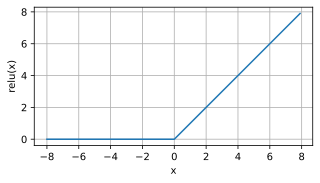

In [4]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

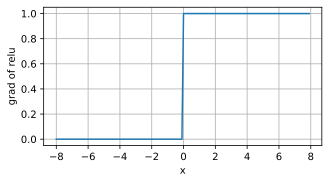

In [5]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

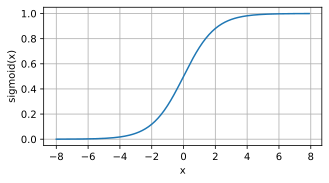

In [6]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

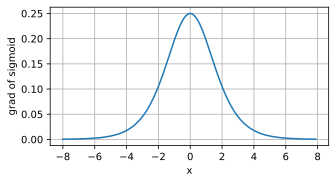

In [7]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

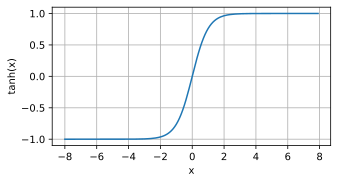

In [8]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

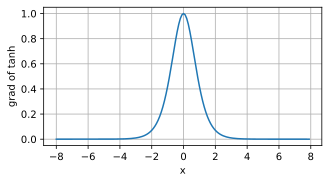

In [9]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

## **5.2 Implementation of Multilayer Perceptrons**

In [10]:
import torch
from torch import nn
from d2l import torch as d2l

In [11]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

In [12]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [13]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

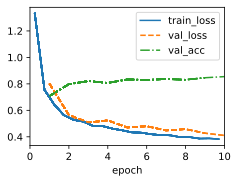

In [15]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [16]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

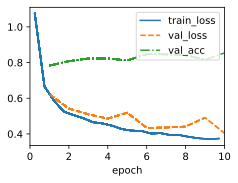

In [17]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

## **5.3 Forward Propagation, Backward Propagation, and Computational Graphs**
:label:sec_backprop

So far, we have trained our models with minibatch stochastic gradient descent. However, when we implemented the algorithm, we only worried about the calculations involved in forward propagation through the model. When it came time to calculate the gradients, we just invoked the backpropagation function provided by the deep learning framework.

The automatic calculation of gradients profoundly simplifies the implementation of deep learning algorithms. Before automatic differentiation, even small changes to complicated models required recalculating complicated derivatives by hand. Surprisingly often, academic papers had to allocate numerous pages to deriving update rules. While we must continue to rely on automatic differentiation so we can focus on the interesting parts, you ought to know how these gradients are calculated under the hood if you want to go beyond a shallow understanding of deep learning.

In this section, we take a deep dive into the details of backward propagation (more commonly called backpropagation). To convey some insight for both the techniques and their implementations, we rely on some basic mathematics and computational graphs. To start, we focus our exposition on a one-hidden-layer MLP with weight decay ( ℓ2  regularization, to be described in subsequent chapters).

Forward Propagation
Forward propagation (or forward pass) refers to the calculation and storage of intermediate variables (including outputs) for a neural network in order from the input layer to the output layer. We now work step-by-step through the mechanics of a neural network with one hidden layer. This may seem tedious but in the eternal words of funk virtuoso James Brown, you must "pay the cost to be the boss".

For the sake of simplicity, let's assume that the input example is  x∈Rd  and that our hidden layer does not include a bias term. Here the intermediate variable is:

z=W(1)x,

where  W(1)∈Rh×d  is the weight parameter of the hidden layer. After running the intermediate variable  z∈Rh  through the activation function  ϕ  we obtain our hidden activation vector of length  h :

h=ϕ(z).

The hidden layer output  h  is also an intermediate variable. Assuming that the parameters of the output layer possess only a weight of  W(2)∈Rq×h , we can obtain an output layer variable with a vector of length  q :

o=W(2)h.

Assuming that the loss function is  l  and the example label is  y , we can then calculate the loss term for a single data example,

L=l(o,y).

As we will see the definition of  ℓ2  regularization to be introduced later, given the hyperparameter  λ , the regularization term is

s=λ2(∥W(1)∥2F+∥W(2)∥2F),
:eqlabel:eq_forward-s

where the Frobenius norm of the matrix is simply the  ℓ2  norm applied after flattening the matrix into a vector. Finally, the model's regularized loss on a given data example is:

J=L+s.

We refer to  J  as the objective function in the following discussion.

Computational Graph of Forward Propagation
Plotting computational graphs helps us visualize the dependencies of operators and variables within the calculation. :numref:fig_forward contains the graph associated with the simple network described above, where squares denote variables and circles denote operators. The lower-left corner signifies the input and the upper-right corner is the output. Notice that the directions of the arrows (which illustrate data flow) are primarily rightward and upward.

Computational graph of forward propagation. :label:fig_forward

Backpropagation
Backpropagation refers to the method of calculating the gradient of neural network parameters. In short, the method traverses the network in reverse order, from the output to the input layer, according to the chain rule from calculus. The algorithm stores any intermediate variables (partial derivatives) required while calculating the gradient with respect to some parameters. Assume that we have functions  Y=f(X)  and  Z=g(Y) , in which the input and the output  X,Y,Z  are tensors of arbitrary shapes. By using the chain rule, we can compute the derivative of  Z  with respect to  X  via

∂Z∂X=prod(∂Z∂Y,∂Y∂X).

Here we use the  prod  operator to multiply its arguments after the necessary operations, such as transposition and swapping input positions, have been carried out. For vectors, this is straightforward: it is simply matrix--matrix multiplication. For higher dimensional tensors, we use the appropriate counterpart. The operator  prod  hides all the notational overhead.

Recall that the parameters of the simple network with one hidden layer, whose computational graph is in :numref:fig_forward, are  W(1)  and  W(2) . The objective of backpropagation is to calculate the gradients  ∂J/∂W(1)  and  ∂J/∂W(2) . To accomplish this, we apply the chain rule and calculate, in turn, the gradient of each intermediate variable and parameter. The order of calculations are reversed relative to those performed in forward propagation, since we need to start with the outcome of the computational graph and work our way towards the parameters. The first step is to calculate the gradients of the objective function  J=L+s  with respect to the loss term  L  and the regularization term  s :

∂J∂L=1and∂J∂s=1.

Next, we compute the gradient of the objective function with respect to variable of the output layer  o  according to the chain rule:

∂J∂o=prod(∂J∂L,∂L∂o)=∂L∂o∈Rq.

Next, we calculate the gradients of the regularization term with respect to both parameters:

∂s∂W(1)=λW(1)and∂s∂W(2)=λW(2).

Now we are able to calculate the gradient  ∂J/∂W(2)∈Rq×h  of the model parameters closest to the output layer. Using the chain rule yields:

∂J∂W(2)=prod(∂J∂o,∂o∂W(2))+prod(∂J∂s,∂s∂W(2))=∂J∂oh⊤+λW(2).
:eqlabel:eq_backprop-J-h

To obtain the gradient with respect to  W(1)  we need to continue backpropagation along the output layer to the hidden layer. The gradient with respect to the hidden layer output  ∂J/∂h∈Rh  is given by

∂J∂h=prod(∂J∂o,∂o∂h)=W(2)⊤∂J∂o.

Since the activation function  ϕ  applies elementwise, calculating the gradient  ∂J/∂z∈Rh  of the intermediate variable  z  requires that we use the elementwise multiplication operator, which we denote by  ⊙ :

∂J∂z=prod(∂J∂h,∂h∂z)=∂J∂h⊙ϕ′(z).

Finally, we can obtain the gradient  ∂J/∂W(1)∈Rh×d  of the model parameters closest to the input layer. According to the chain rule, we get

∂J∂W(1)=prod(∂J∂z,∂z∂W(1))+prod(∂J∂s,∂s∂W(1))=∂J∂zx⊤+λW(1).

Training Neural Networks
When training neural networks, forward and backward propagation depend on each other. In particular, for forward propagation, we traverse the computational graph in the direction of dependencies and compute all the variables on its path. These are then used for backpropagation where the compute order on the graph is reversed.

Take the aforementioned simple network as an illustrative example. On the one hand, computing the regularization term :eqref:eq_forward-s during forward propagation depends on the current values of model parameters  W(1)  and  W(2) . They are given by the optimization algorithm according to backpropagation in the most recent iteration. On the other hand, the gradient calculation for the parameter :eqref:eq_backprop-J-h during backpropagation depends on the current value of the hidden layer output  h , which is given by forward propagation.

Therefore when training neural networks, once model parameters are initialized, we alternate forward propagation with backpropagation, updating model parameters using gradients given by backpropagation. Note that backpropagation reuses the stored intermediate values from forward propagation to avoid duplicate calculations. One of the consequences is that we need to retain the intermediate values until backpropagation is complete. This is also one of the reasons why training requires significantly more memory than plain prediction. Besides, the size of such intermediate values is roughly proportional to the number of network layers and the batch size. Thus, training deeper networks using larger batch sizes more easily leads to out-of-memory errors.

Summary
Forward propagation sequentially calculates and stores intermediate variables within the computational graph defined by the neural network. It proceeds from the input to the output layer. Backpropagation sequentially calculates and stores the gradients of intermediate variables and parameters within the neural network in the reversed order. When training deep learning models, forward propagation and backpropagation are interdependent, and training requires significantly more memory than prediction.

## **5.4 Numerical Stability and Initialization**

In [18]:
%matplotlib inline
import torch
from d2l import torch as d2l

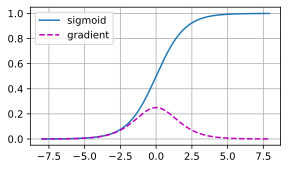

In [19]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

In [20]:
M = torch.normal(0, 1, size=(4, 4))
print('a single matrix \n',M)
for i in range(100):
    M = M @ torch.normal(0, 1, size=(4, 4))
print('after multiplying 100 matrices\n', M)

a single matrix 
 tensor([[-0.6906,  0.9134, -1.8331, -1.5210],
        [-1.2086, -0.3172,  0.4645, -0.4169],
        [-1.0635, -2.0163,  1.2904,  0.8281],
        [ 1.9943,  0.9522,  0.7668,  0.6528]])
after multiplying 100 matrices
 tensor([[ 4.2556e+25, -4.1137e+25,  1.6266e+25,  3.8836e+25],
        [-7.5142e+24,  7.2637e+24, -2.8721e+24, -6.8573e+24],
        [-4.0246e+25,  3.8904e+25, -1.5383e+25, -3.6728e+25],
        [-7.2073e+24,  6.9669e+24, -2.7547e+24, -6.5771e+24]])


## **5.5 Generalization in Deep Learning**


In :numref:`chap_regression` and :numref:`chap_classification`,
we tackled regression and classification problems
by fitting linear models to training data.
In both cases, we provided practical algorithms
for finding the parameters that maximized
the likelihood of the observed training labels.
And then, towards the end of each chapter,
we recalled that fitting the training data
was only an intermediate goal.
Our real quest all along was to discover *general patterns*
on the basis of which we can make accurate predictions
even on new examples drawn from the same underlying population.
Machine learning researchers are *consumers* of optimization algorithms.
Sometimes, we must even develop new optimization algorithms.
But at the end of the day, optimization is merely a means to an end.
At its core, machine learning is a statistical discipline
and we wish to optimize training loss only insofar
as some statistical principle (known or unknown)
leads the resulting models to generalize beyond the training set.


On the bright side, it turns out that deep neural networks
trained by stochastic gradient descent generalize remarkably well
across myriad prediction problems, spanning computer vision;
natural language processing; time series data; recommender systems;
electronic health records; protein folding;
value function approximation in video games
and board games; and numerous other domains.
On the downside, if you were looking
for a straightforward account
of either the optimization story
(why we can fit them to training data)
or the generalization story
(why the resulting models generalize to unseen examples),
then you might want to pour yourself a drink.
While our procedures for optimizing linear models
and the statistical properties of the solutions
are both described well by a comprehensive body of theory,
our understanding of deep learning
still resembles the wild west on both fronts.

Both the theory and practice of deep learning
are rapidly evolving,
with theorists adopting new strategies
to explain what's going on,
even as practitioners continue
to innovate at a blistering pace,
building arsenals of heuristics for training deep networks
and a body of intuitions and folk knowledge
that provide guidance for deciding
which techniques to apply in which situations.

The summary of the present moment is that the theory of deep learning
has produced promising lines of attack and scattered fascinating results,
but still appears far from a comprehensive account
of both (i) why we are able to optimize neural networks
and (ii) how models learned by gradient descent
manage to generalize so well, even on high-dimensional tasks.
However, in practice, (i) is seldom a problem
(we can always find parameters that will fit all of our training data)
and thus understanding generalization is far the bigger problem.
On the other hand, even absent the comfort of a coherent scientific theory,
practitioners have developed a large collection of techniques
that may help you to produce models that generalize well in practice.
While no pithy summary can possibly do justice
to the vast topic of generalization in deep learning,
and while the overall state of research is far from resolved,
we hope, in this section, to present a broad overview
of the state of research and practice.


## Revisiting Overfitting and Regularization

According to the "no free lunch" theorem of :citet:`wolpert1995no`,
any learning algorithm generalizes better on data with certain distributions, and worse with other distributions.
Thus, given a finite training set,
a model relies on certain assumptions:
to achieve human-level performance
it may be useful to identify *inductive biases*
that reflect how humans think about the world.
Such inductive biases show preferences
for solutions with certain properties.
For example,
a deep MLP has an inductive bias
towards building up a complicated function by the composition of simpler functions.

With machine learning models encoding inductive biases,
our approach to training them
typically consists of two phases: (i) fit the training data;
and (ii) estimate the *generalization error*
(the true error on the underlying population)
by evaluating the model on holdout data.
The difference between our fit on the training data
and our fit on the test data is called the *generalization gap* and when this is large,
we say that our models *overfit* to the training data.
In extreme cases of overfitting,
we might exactly fit the training data,
even when the test error remains significant.
And in the classical view,
the interpretation is that our models are too complex,
requiring that we either shrink the number of features,
the number of nonzero parameters learned,
or the size of the parameters as quantified.
Recall the plot of model complexity compared with loss
(:numref:`fig_capacity_vs_error`)
from :numref:`sec_generalization_basics`.


However deep learning complicates this picture in counterintuitive ways.
First, for classification problems,
our models are typically expressive enough
to perfectly fit every training example,
even in datasets consisting of millions
:cite:`zhang2021understanding`.
In the classical picture, we might think
that this setting lies on the far right extreme
of the model complexity axis,
and that any improvements in generalization error
must come by way of regularization,
either by reducing the complexity of the model class,
or by applying a penalty, severely constraining
the set of values that our parameters might take.
But that is where things start to get weird.

Strangely, for many deep learning tasks
(e.g., image recognition and text classification)
we are typically choosing among model architectures,
all of which can achieve arbitrarily low training loss
(and zero training error).
Because all models under consideration achieve zero training error,
*the only avenue for further gains is to reduce overfitting*.
Even stranger, it is often the case that
despite fitting the training data perfectly,
we can actually *reduce the generalization error*
further by making the model *even more expressive*,
e.g., adding layers, nodes, or training
for a larger number of epochs.
Stranger yet, the pattern relating the generalization gap
to the *complexity* of the model (as captured, for example, in the depth or width of the networks)
can be non-monotonic,
with greater complexity hurting at first
but subsequently helping in a so-called "double-descent" pattern
:cite:`nakkiran2021deep`.
Thus the deep learning practitioner possesses a bag of tricks,
some of which seemingly restrict the model in some fashion
and others that seemingly make it even more expressive,
and all of which, in some sense, are applied to mitigate overfitting.

Complicating things even further,
while the guarantees provided by classical learning theory
can be conservative even for classical models,
they appear powerless to explain why it is
that deep neural networks generalize in the first place.
Because deep neural networks are capable of fitting
arbitrary labels even for large datasets,
and despite the use of familiar methods such as $\ell_2$ regularization,
traditional complexity-based generalization bounds,
e.g., those based on the VC dimension
or Rademacher complexity of a hypothesis class
cannot explain why neural networks generalize.

## Inspiration from Nonparametrics

Approaching deep learning for the first time,
it is tempting to think of them as parametric models.
After all, the models *do* have millions of parameters.
When we update the models, we update their parameters.
When we save the models, we write their parameters to disk.
However, mathematics and computer science are riddled
with counterintuitive changes of perspective,
and surprising isomorphisms between seemingly different problems.
While neural networks clearly *have* parameters,
in some ways it can be more fruitful
to think of them as behaving like nonparametric models.
So what precisely makes a model nonparametric?
While the name covers a diverse set of approaches,
one common theme is that nonparametric methods
tend to have a level of complexity that grows
as the amount of available data grows.

Perhaps the simplest example of a nonparametric model
is the $k$-nearest neighbor algorithm (we will cover more nonparametric models later, for example in :numref:`sec_attention-pooling`).
Here, at training time,
the learner simply memorizes the dataset.
Then, at prediction time,
when confronted with a new point $\mathbf{x}$,
the learner looks up the $k$ nearest neighbors
(the $k$ points $\mathbf{x}_i'$ that minimize
some distance $d(\mathbf{x}, \mathbf{x}_i')$).
When $k=1$, this algorithm is called $1$-nearest neighbors,
and the algorithm will always achieve a training error of zero.
That however, does not mean that the algorithm will not generalize.
In fact, it turns out that under some mild conditions,
the 1-nearest neighbor algorithm is consistent
(eventually converging to the optimal predictor).


Note that $1$-nearest neighbor requires that we specify
some distance function $d$, or equivalently,
that we specify some vector-valued basis function $\phi(\mathbf{x})$
for featurizing our data.
For any choice of the distance metric,
we will achieve zero training error
and eventually reach an optimal predictor,
but different distance metrics $d$
encode different inductive biases
and with a finite amount of available data
will yield different predictors.
Different choices of the distance metric $d$
represent different assumptions about the underlying patterns
and the performance of the different predictors
will depend on how compatible the assumptions
are with the observed data.

In a sense, because neural networks are over-parametrized,
possessing many more parameters than are needed to fit the training data,
they tend to *interpolate* the training data (fitting it perfectly)
and thus behave, in some ways, more like nonparametric models.
More recent theoretical research has established
deep connection between large neural networks
and nonparametric methods, notably kernel methods.
In particular, :citet:`Jacot.Grabriel.Hongler.2018`
demonstrated that in the limit, as multilayer perceptrons
with randomly initialized weights grow infinitely wide,
they become equivalent to (nonparametric) kernel methods
for a specific choice of the kernel function
(essentially, a distance function),
which they call the neural tangent kernel.
While current neural tangent kernel models may not fully explain
the behavior of modern deep networks,
their success as an analytical tool
underscores the usefulness of nonparametric modeling
for understanding the behavior of over-parametrized deep networks.


## Early Stopping

While deep neural networks are capable of fitting arbitrary labels,
even when labels are assigned incorrectly or randomly
:cite:`zhang2021understanding`,
this capability only emerges over many iterations of training.
A new line of work :cite:`Rolnick.Veit.Belongie.Shavit.2017`
has revealed that in the setting of label noise,
neural networks tend to fit cleanly labeled data first
and only subsequently to interpolate the mislabeled data.
Moreover, it has been established that this phenomenon
translates directly into a guarantee on generalization:
whenever a model has fitted the cleanly labeled data
but not randomly labeled examples included in the training set,
it has in fact generalized :cite:`Garg.Balakrishnan.Kolter.Lipton.2021`.

Together these findings help to motivate *early stopping*,
a classic technique for regularizing deep neural networks.
Here, rather than directly constraining the values of the weights,
one constrains the number of epochs of training.
The most common way to determine the stopping criterion
is to monitor validation error throughout training
(typically by checking once after each epoch)
and to cut off training when the validation error
has not decreased by more than some small amount $\epsilon$
for some number of epochs.
This is sometimes called a *patience criterion*.
As well as the potential to lead to better generalization
in the setting of noisy labels,
another benefit of early stopping is the time saved.
Once the patience criterion is met, one can terminate training.
For large models that might require days of training
simultaneously across eight or more GPUs,
well-tuned early stopping can save researchers days of time
and can save their employers many thousands of dollars.

Notably, when there is no label noise and datasets are *realizable*
(the classes are truly separable, e.g., distinguishing cats from dogs),
early stopping tends not to lead to significant improvements in generalization.
On the other hand, when there is label noise,
or intrinsic variability in the label
(e.g., predicting mortality among patients),
early stopping is crucial.
Training models until they interpolate noisy data is typically a bad idea.


## Classical Regularization Methods for Deep Networks

In :numref:`chap_regression`, we described
several  classical regularization techniques
for constraining the complexity of our models.
In particular, :numref:`sec_weight_decay`
introduced a method called weight decay,
which consists of adding a regularization term to the loss function
in order to penalize large values of the weights.
Depending on which weight norm is penalized
this technique is known either as ridge regularization (for $\ell_2$ penalty)
or lasso regularization (for an $\ell_1$ penalty).
In the classical analysis of these regularizers,
they are considered as sufficiently restrictive on the values
that the weights can take to prevent the model from fitting arbitrary labels.

In deep learning implementations,
weight decay remains a popular tool.
However, researchers have noted
that typical strengths of $\ell_2$ regularization
are insufficient to prevent the networks
from interpolating the data :cite:`zhang2021understanding` and thus the benefits if interpreted
as regularization might only make sense
in combination with the early stopping criterion.
Absent early stopping, it is possible
that just like the number of layers
or number of nodes (in deep learning)
or the distance metric (in 1-nearest neighbor),
these methods may lead to better generalization
not because they meaningfully constrain
the power of the neural network
but rather because they somehow encode inductive biases
that are better compatible with the patterns
found in datasets of interests.
Thus, classical regularizers remain popular
in deep learning implementations,
even if the theoretical rationale
for their efficacy may be radically different.

Notably, deep learning researchers have also built
on techniques first popularized
in classical regularization contexts,
such as adding noise to model inputs.
In the next section we will introduce
the famous dropout technique
(invented by :citet:`Srivastava.Hinton.Krizhevsky.ea.2014`),
which has become a mainstay of deep learning,
even as the theoretical basis for its efficacy
remains similarly mysterious.


## Summary

Unlike classical linear models,
which tend to have fewer parameters than examples,
deep networks tend to be over-parametrized,
and for most tasks are capable
of perfectly fitting the training set.
This *interpolation regime* challenges
many hard fast-held intuitions.
Functionally, neural networks look like parametric models.
But thinking of them as nonparametric models
can sometimes be a more reliable source of intuition.
Because it is often the case that all deep networks under consideration
are capable of fitting all of the training labels,
nearly all gains must come by mitigating overfitting
(closing the *generalization gap*).
Paradoxically, the interventions
that reduce the generalization gap
sometimes appear to increase model complexity
and at other times appear to decrease complexity.
However, these methods seldom decrease complexity
sufficiently for classical theory
to explain the generalization of deep networks,
and *why certain choices lead to improved generalization*
remains for the most part a massive open question
despite the concerted efforts of many brilliant researchers.



## **5.6 Dropout**

In [21]:
import torch
from torch import nn
from d2l import torch as d2l

In [22]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [23]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print('dropout_p = 0:', dropout_layer(X, 0))
print('dropout_p = 0.5:', dropout_layer(X, 0.5))
print('dropout_p = 1:', dropout_layer(X, 1))

dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5: tensor([[ 0.,  0.,  4.,  6.,  8., 10., 12., 14.],
        [16.,  0.,  0., 22., 24.,  0.,  0.,  0.]])
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [24]:
class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

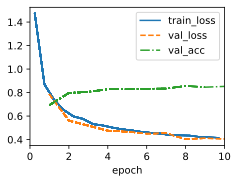

In [25]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [26]:
class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))

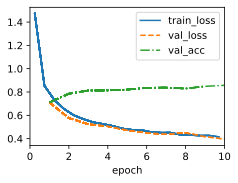

In [27]:
model = DropoutMLP(**hparams)
trainer.fit(model, data)

## **5.7. Predicting House Prices on Kaggle**

In [28]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [29]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

In [30]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

In [31]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


In [32]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [33]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

In [34]:
data.preprocess()
data.train.shape

(1460, 331)

In [35]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                      dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

In [36]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

In [37]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

average validation log mse = 0.18279912918806077


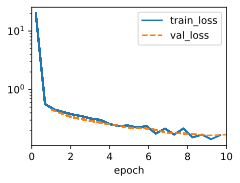

In [38]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

In [39]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)